In [3]:
# Import packages
import ftplib
from contextlib import closing
import urllib.request
import io
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import act

In [4]:
outpath = '/storage/dlhogan/sos/data/ncdfs'

In [5]:
surf_temp_ds=act.io.armfiles.read_netcdf(os.path.join(outpath,f'surf_temp_ds.nc'))
surf_t = surf_temp_ds.where(surf_temp_ds['qc_sfc_ir_temp']==0)['sfc_ir_temp']

In [6]:
met_ds = act.io.armfiles.read_netcdf(os.path.join(outpath,'met_ds.nc'))

In [7]:
def sat_vapor_pressure_ice(T):
    es_surf = 611.21 * np.exp((22.587 * T) / (T+273.86)) # Magnus formula from Huang 2018
    return es_surf

def sat_vapor_pressure_water(T):
    es_surf = 610.94 * np.exp((17.625*T) / (T + 243.04)) # Magnus formula from Huang 2018
    return es_surf

In [47]:
temp_diff = met_ds['temp_mean'] - (surf_temp_ds['sfc_ir_temp'].where(surf_temp_ds['sfc_ir_temp']<=273.15)-273.15)
rh_mean = met_ds['rh_mean'].sel(time=temp_diff.time)/100

t_surf = surf_temp_ds['sfc_ir_temp'].where(surf_temp_ds['sfc_ir_temp']<=273.15)-273.15
meas_temp = met_ds['temp_mean'].compute()
rh = met_ds['rh_mean']
e_air = rh * sat_vapor_pressure_ice(meas_temp)/100
es_surf = sat_vapor_pressure_ice(t_surf)

In [48]:
vpd = (e_air - es_surf)
wspd_arith_mean = met_ds['wspd_arith_mean']
u_vpd = wspd_arith_mean * vpd

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  del sys.path[0]


Text(0, 0.5, 'e - e$_s$ (Pa)')

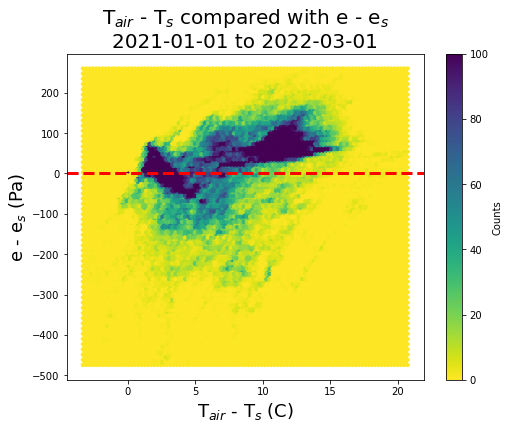

In [76]:
t1 = '2021-01-01'
t2 = '2022-03-01'
time_slice = slice(t1, t2)

x = np.nan_to_num(temp_diff.sel(time=time_slice).values)
y = np.nan_to_num(vpd.sel(time=time_slice).values)

plt.figure(figsize=(8,6))
norm = plt.Normalize(0, 100)

plt.hexbin(x, y, norm=norm, cmap='viridis_r')
plt.axhline(0, color='r', lw=3, ls='--')
plt.colorbar(h, label='Counts')
plt.title('T$_{air}$ - T$_{s}$ compared with e - e$_s$'+ f'\n{t1} to {t2}', size=20)
plt.xlabel('T$_{air}$ - T$_{s}$ (C)', size=18)
plt.ylabel('e - e$_s$ (Pa)', size=18)

In [77]:
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib import cm


def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(8,6))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = 0, vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(cmap='viridis', norm = norm),ax=ax)
    cbar.ax.set_ylabel('Density', size=18)
    ax.axhline(0, color='r', lw=3, ls='--')
    ax.axvline(0, color='black', lw=3, ls='--')

    ax.set_title('T$_{air}$ - T$_{s}$ compared with e - e$_s$'+ f'\n{t1} to {t2}', size=20)
    ax.set_xlabel('T$_{air}$ - T$_{s}$ (C)', size=18)
    ax.set_ylabel('e - e$_s$ (Pa)', size=18)
    ax.set_xlim(-20,20)
    ax.set_ylim(-500,500)

    return ax



<AxesSubplot:title={'center':'T$_{air}$ - T$_{s}$ compared with e - e$_s$\n2022-01-01 to 2022-03-01'}, xlabel='T$_{air}$ - T$_{s}$ (C)', ylabel='e - e$_s$ (Pa)'>

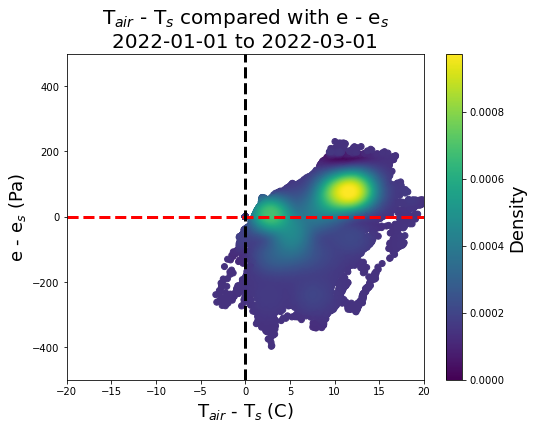

In [83]:
t1 = '2022-01-01'
t2 = '2022-03-01'
time_slice = slice(t1, t2)

x = np.nan_to_num(temp_diff.sel(time=time_slice).values)
y = np.nan_to_num(vpd.sel(time=time_slice).values)

density_scatter( x, y, bins = [10,10] )

<AxesSubplot:title={'center':'T$_{air}$ - T$_{s}$ compared with e - e$_s$\n2021-12-23 to 2021-12-31'}, xlabel='T$_{air}$ - T$_{s}$ (C)', ylabel='e - e$_s$ (Pa)'>

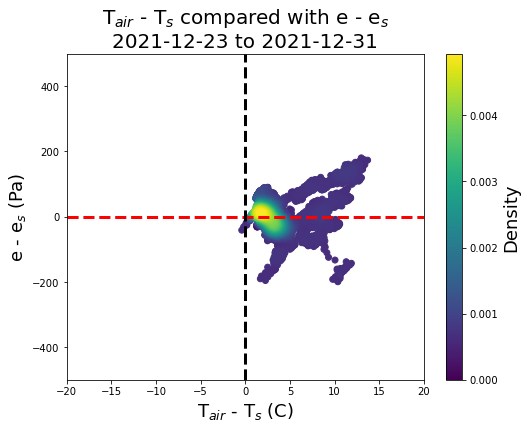

In [84]:
t1 = '2021-12-23'
t2 = '2021-12-31'
time_slice = slice(t1, t2)

x = np.nan_to_num(temp_diff.sel(time=time_slice).values)
y = np.nan_to_num(vpd.sel(time=time_slice).values)

density_scatter( x, y, bins = [10,10] )